In [1]:
import keras 
import tensorflow as tf
from keras.datasets import cifar10
import numpy as np
from keras.callbacks import History 
import matplotlib.pyplot as plt
from keras.datasets import imdb #cargo los datos del imdb
from numpy import genfromtxt
from keras.utils import to_categorical
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [2]:
def randomize(x,y):
    #x matriz de datos (datos x dimension)
    #y matriz de datos verdaderos (datos x 1)
    indices = np.random.choice(x.shape[0], x.shape[0], replace=False)
    x = x[indices]
    y = y[indices]
    return x,y

In [3]:
#cargo los datos
data = genfromtxt('pima-indians-diabetes.csv', delimiter=',') #cargo los datos
x_total = data[:,:8] #valores de los datos relevantes para saber si tiene/no tiene diabetes
y_total = data[:,8] #diagnostico (1 o 0, si o no tiene la enfermedad)
n_datos = x_total.shape[0] #o sea, n_datos = 768
n_dim = x_total.shape[1] #o sea, n_dim = 8
#corrijo los valores que daban cero por el promedio de los que no son cero 
j = 1
i = 0
while j <= 6:
    n_zero = (x_total[:,j][x_total[:,j]!=0]).shape[0] #cosas en cada fila no cero
    mean = sum(x_total[:,j])/n_zero #suma de las cosas (los que son =0 no van a contar)
    while i < n_datos:
        if x_total[i,j] == 0:
            x_total[i,j] = mean
        i += 1
    j += 1

In [4]:
#creo datos de test y train primero, como lo haciamos antes
n_datos = x_total.shape[0] #o sea, n_datos = 768
n_dim = x_total.shape[1] #o sea, n_dim = 8
cant_test = int(0.2*n_datos)
x_total,y_total = randomize(x_total,y_total)
x_train = x_total[cant_test:,:]
y_train = y_total[cant_test:]
x_test = x_total[:cant_test,:]
y_test = y_total[:cant_test]
mean = np.mean(x_train,axis=0)
sigma = np.std(x_train,axis=0)
x_train = (x_train - mean)/sigma
x_test = (x_test - mean)/sigma

In [6]:
num_folds = 5
acc_folds = []
#defino algunas constantes que son utiles, como en problemas anteriores
n_capa1 = 1600 #dice 2 porque iba a ser de la capa 2
n_capa2 = 80
n_capa3 = 1 #idem. por prueba empirica y tiempo, al ver que funcionaba lo deje asi. 
rg = 0
num_fold = 1
epocas = 200 #cantidad de epocas
kf = KFold(n_splits=num_folds)
kf.get_n_splits(x_total)
for train, test in kf.split(x_total):
    print('Fold number: ',num_fold)
    x = keras.layers.Input(shape=(n_dim,)) #capa de input
    l1 = keras.layers.Dense(units=n_capa1, activation='relu',kernel_initializer = keras.initializers.RandomNormal(stddev=0.8),kernel_regularizer=keras.regularizers.l2(rg))(x)
    l2 = keras.layers.Dense(units=n_capa2, activation='relu',kernel_initializer = keras.initializers.RandomNormal(stddev=0.8),kernel_regularizer=keras.regularizers.l2(rg))(l1)
    l3 = keras.layers.Dense(units=n_capa3, activation='sigmoid',kernel_initializer = keras.initializers.RandomNormal(stddev=0.8),kernel_regularizer=keras.regularizers.l2(rg))(l2)
    model = keras.Model(inputs=x, outputs=l3)
    optimizer = keras.optimizers.SGD(1e-3)
    model.compile(optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['acc'])
    history = model.fit(x_total[train], y_total[train], epochs=epocas, 
                        validation_data=(x_total[test], y_total[test]),shuffle=True,batch_size=10, verbose=0)
    acc_folds.append(history.history['val_acc'])
    num_fold = num_fold + 1

Fold number:  1
Fold number:  2
Fold number:  3
Fold number:  4
Fold number:  5


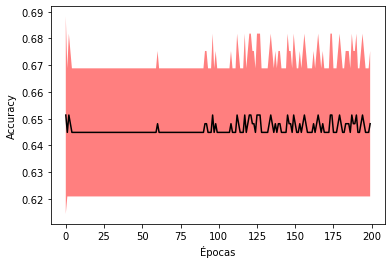

In [7]:
max_lists = max(acc_folds)
min_lists = min(acc_folds)
e = range(epocas)
mean_folds = (np.array(max_lists) + np.array(min_lists))
mean_folds = np.array(mean_folds)*0.5
plt.plot(mean_folds,c='k')
plt.fill_between(e,min_lists,mean_folds,facecolor='red',alpha=0.5)
plt.fill_between(e,mean_folds,max_lists,facecolor='red',alpha=0.5)
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.savefig('ej62_2_lossacc.pdf')
plt.show()

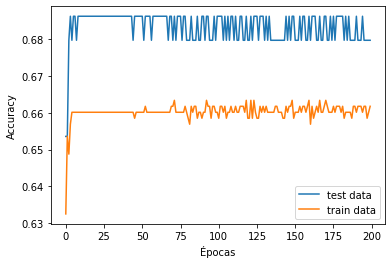

In [8]:
plt.plot(history.history['val_acc'],label='test data')
plt.plot(history.history['acc'],label='train data')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.savefig('ej62_1_lossacc.pdf')